In [1]:
import pypsa
import numpy as np
import os
import sys
import re
import warnings
import seaborn as sns
warnings.filterwarnings("ignore")

from pathlib import Path

sys.path.append(str(Path.cwd() / ".." / "scripts"))

from make_egs_plots import plot_timeseries, plot_geothermal_map

In [2]:
model_name = "elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc"
dir_template = "egs_sweep_{}"

In [3]:
costs_2_evaluate = np.arange(100000, 555000, 5000)

energies, capacities, costs_list = list(), list(), list() 
capital_cost_steps = list()

for costs in costs_2_evaluate:

    model_path = Path.cwd() / dir_template.format(int(costs)) / "postnetworks" / model_name

    try:
        n = pypsa.Network(model_path)
    except FileNotFoundError:
        continue

    # capcost = re.sub("[^0-9]", "", ex)
    print("+========================== Capital Cost {} ================================".format(costs))
    print(model_path)

    energy, cap, cost = plot_geothermal_map(n, "AC", return_data=True, do_plot=False)

    energies.append(energy)    
    capacities.append(cap)    
    costs_list.append(cost)    
    capital_cost_steps.append(costs)
    # plot_timeseries(n, "all", "AC")

INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 100000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_100000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 105000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_105000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 110000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_110000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 115000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_115000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 120000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_120000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 125000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_125000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 130000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_130000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 135000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_135000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 140000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_140000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 145000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_145000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 150000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_150000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 155000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_155000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 160000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_160000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 165000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_165000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 170000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_170000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 175000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_175000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 180000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_180000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 185000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_185000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 190000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_190000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 195000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_195000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 200000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_200000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 205000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_205000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 215000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_215000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 220000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_220000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 225000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_225000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 230000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_230000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 235000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_235000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 240000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_240000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 245000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_245000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 250000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_250000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 255000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_255000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 260000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_260000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 265000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_265000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 270000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_270000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 275000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_275000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 280000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_280000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 285000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_285000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 290000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_290000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 295000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_295000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 300000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_300000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 305000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_305000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 310000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_310000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 315000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_315000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 320000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_320000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 325000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_325000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 330000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_330000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 335000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_335000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 340000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_340000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 345000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_345000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 350000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_350000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 355000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_355000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 360000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_360000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 365000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_365000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 370000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_370000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 375000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_375000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 380000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_380000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 385000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_385000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 390000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_390000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 395000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_395000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 400000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_400000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 405000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_405000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 410000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_410000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 415000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_415000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 420000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_420000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 425000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_425000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 430000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_430000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 435000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_435000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 440000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_440000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 445000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_445000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 450000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_450000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 455000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_455000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 460000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_460000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 465000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_465000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 470000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_470000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 475000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_475000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 480000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_480000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 485000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_485000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 490000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_490000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 495000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_495000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 500000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_500000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 505000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_505000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 510000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_510000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 515000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_515000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 520000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_520000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 525000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_525000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 530000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_530000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 535000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_535000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 540000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_540000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 545000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_545000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc


In [4]:
from vresutils.costdata import annuity

an = annuity(30, 0.07)

def capex_to_cc(capex, lt, dr):
    """ad-hoc equation"""
    return annuity(lt, dr) * capex + 0.02*capex

def cc_to_capex(cc, lt, dr):
    return cc / (0.02 + annuity(lt, dr))

capex_to_cc(cc_to_capex(1, 30, 0.07), 30, 0.07)

0.9999999999999999

In [6]:
import pandas as pd
capacities_df = pd.concat(capacities, axis=1)
capacities_df.columns = capital_cost_steps

# capacities_df.to_csv("capacities_europe.csv")

In [7]:
import pandas as pd
import numpy as np

capex = pd.Series(cc_to_capex(np.array(capital_cost_steps), 30, 0.07))
country_shares = pd.DataFrame(index=energies[0].groupby(level=0).sum().index.tolist() + ["EU"])

for costs, df in zip(capital_cost_steps, energies):

    idx = pd.IndexSlice
    gt = df.loc[idx[:, "geothermal heat"]]

    totals = df.groupby(level=0).sum()
    totals = pd.concat((totals, pd.Series({"EU": totals.sum()})))
    
    diff = totals.drop(index=["EU"]).index.difference(gt.index)
    gt = pd.concat((
        gt, 
        pd.Series(np.zeros_like(diff), index=diff), 
        pd.Series({"EU": gt.sum()})))

    percentages = gt.divide(totals)

    country_shares[costs] = percentages


country_shares.to_csv("country_shares.csv")
totals.to_csv("total_energies.csv")
capex.to_csv("capex.csv")

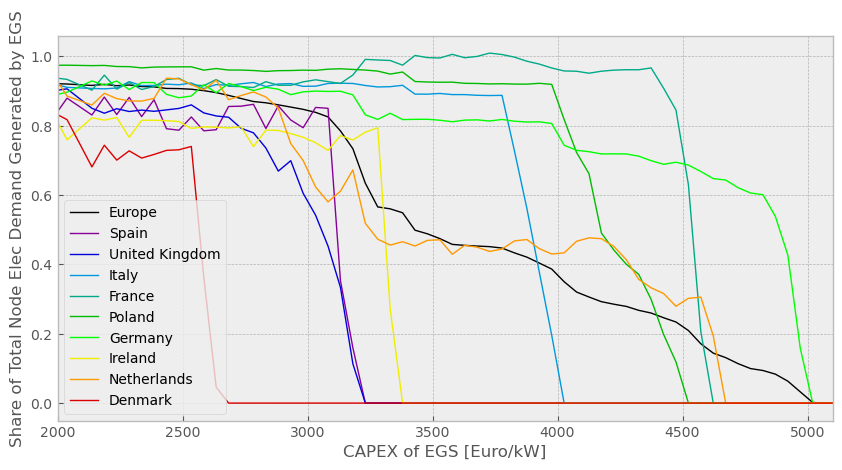

In [9]:
import pycountry
import matplotlib.pyplot as plt
plt.style.use("bmh")

country_mapper = {country.alpha_2: country.name for country in pycountry.countries}
country_mapper["EU"] = "Europe"

n_show = 10

show_countries = totals.sort_values(ascending=False).iloc[:n_show].index 

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# viridis, plasma, inferno, magma, cividis, cool, winter, copper, gist_earth, turbo

colormap = plt.cm.nipy_spectral #I suggest to use nipy_spectral, Set1,Paired
ax.set_prop_cycle("color", [colormap(i) for i in np.linspace(0, 1, n_show+1)])


# x = country_shares.columns.values.astype(float)
x = capex.values * 1e-3

for country in country_shares.loc[show_countries].index:
    
    if country == "EU":
        linewidth = 2. 
    else:
        linewidth = 1. 
        
    ax.plot(x,
            country_shares.loc[country].values,
            label=country_mapper[country[:2]],
            linewidth=linewidth, 
            ) 

ax.set_xlabel("CAPEX of EGS [Euro/kW]")
ax.set_ylabel("Share of Total Node Elec Demand Generated by EGS")
ax.legend()

ax.set_xlim(2e3, 5.1e3)

ax.set_title("")

plt.show()

In [10]:
ov = pd.read_csv(Path.cwd() / ".." / "resources" / "egs_test" / "egs_overlap_matrix_s_37.csv", index_col=0)
pot_2015 = pd.read_csv(Path.cwd() / ".." / "resources" / "egs_potentials_by_year" / "egs_potentials_s_37_2015.csv")

gdf = gpd.GeoDataFrame(pot_2015.drop(columns=["geometry", "dh_share.1"]), geometry=gpd.GeoSeries.from_wkt(pot_2015.geometry))
gdf.index = pot_2015.geometry


gdf.head()

NameError: name 'gpd' is not defined

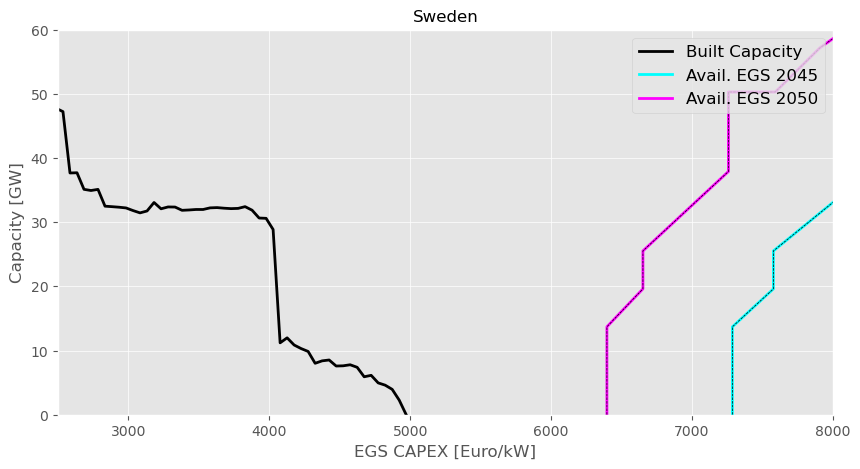

In [11]:
import numpy as np
import pycountry
import sys
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
plt.style.use("ggplot")

network_file = "../resources/egs_test/regions_onshore_elec_s_37.geojson"
network_regions = gpd.read_file(network_file).set_crs(epsg=4326)
network_regions.index = network_regions["name"]

cap_df = pd.read_csv("capacities_europe.csv").rename(columns={"Unnamed: 0": 'node'})

def get_region_capex_pnom(region_name, year):


    # prepare year egs data
    egs_data = pd.read_csv(Path.cwd() / 
                           ".." / 
                           "resources" / 
                           "egs_potentials_by_year" / 
                           f"egs_potentials_s_37_{year}.csv")
    egs_data_gdf = gpd.GeoDataFrame(egs_data.drop(columns=["geometry", "dh_share.1"]),
                           geometry=gpd.GeoSeries.from_wkt(egs_data.geometry))


    if not region_name == "EU":
        # prepare node geometry
        region_geom = network_regions.geometry.loc[region_name]

        overlap = egs_data_gdf.geometry.apply(lambda geom: geom.intersection(region_geom).area)
        overlap = overlap.loc[overlap > 0.]

        if overlap.empty:
            return pd.DataFrame(columns=["capex", "p_nom_max"])
            
        egs_data = egs_data.loc[overlap.index]
        p_noms = egs_data["p_nom_max"].multiply(overlap)

    else:    
        p_noms = egs_data["p_nom_max"]

    capexes = egs_data["CAPEX"] * 1e3
    result = (
        pd.DataFrame({
            "capex": capexes,
            "p_nom_max": p_noms,
        })
        .sort_values(by="capex", ascending=True)
    )
    result["p_nom_max"] = result['p_nom_max'].cumsum()

    return result
    
# country_shares.to_csv("country_shares.csv")
# totals.to_csv("total_energies.csv")

def make_country_summary(node):
    years = np.arange(2015, 2055, 5)

    # shares = pd.read_csv("country_shares.csv", index_col=0).loc[node]
    # total_energy = pd.read_csv("total_energies.csv", index_col=0).loc[node]

    if node == "EU":
        gt = cap_df.drop(columns=["node"])
        gt = gt.loc[gt.carrier == "geothermal heat"].drop(columns=["carrier"]).sum()
    
    else:
        subset_cap = cap_df.loc[cap_df.node == node].drop(columns=["node"])
        total_cap = subset_cap.drop(columns=["carrier"]).sum()
        gt = subset_cap.loc[subset_cap.carrier == "geothermal heat"].drop(columns=["carrier"])

    fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    try:
        x = cc_to_capex(np.array(gt.columns).astype(float), 30, 0.07)
    except AttributeError:
        x = cc_to_capex(np.array(gt.index).astype(float), 30, 0.07)
    ax.plot(x*1e-3,
            gt.values.flatten() * 1e-3,
            linewidth=2.,
            label="Built Capacity",
            color="k",
            )

    ax.legend()
    ax.set_xlabel("EGS CAPEX [Euro/kW]")
    ax.set_ylabel("Capacity [GW]")
    
    if node in good_xlims:
        ax.set_xlim(good_xlims[node])
        ax.set_ylim(good_ylims[node])

    # viridis, plasma, inferno, magma, cividis, cool, winter, copper, gist_earth, turbo
    colormap = plt.cm.cool #I suggest to use nipy_spectral, Set1,Paired
    
    num_colors = 0

    for year in years:
        data = get_region_capex_pnom(node, year)
        if data.empty:
            continue

        x, y = data["capex"].values * 1e-3, data["p_nom_max"].values

        if node in good_xlims:
            if x[0] > good_xlims[node][1] or x[-1] < good_xlims[node][0]:
                continue
        num_colors += 1

    ax.set_prop_cycle("color", [colormap(i) for i in np.linspace(0, 1, num_colors)])

    for year in years:
        data = get_region_capex_pnom(node, year)
        if data.empty:
            continue

        x, y = data["capex"].values * 1e-3, data["p_nom_max"].values.tolist()
        x = x.tolist()

        if node in good_xlims:
            if x[0] > good_xlims[node][1] or x[-1] < good_xlims[node][0]:
                continue
        
        if y[0] > 0:
            y = [0.] + y
            x = [x[0]] + x

        if len(x) == 1:
            ax.scatter(x, y, s=30, label=f"Avail. EGS {year}", )
            continue

        ax.plot(x, y, label=f"Avail. EGS {year}", linewidth=2.)
        ax.plot(x, y, linestyle="--", linewidth=0.5, color="k")
    # ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha="right")
    ax.legend(loc='upper right')

    if node != "EU":
        country = pycountry.countries.get(alpha_2=node[:2]).name
    else:
        country = "Europe" 

    # ax.set_title(f"{country}; EGS built by PyPSA-Eur vs EGS Potential Estimated in Aghahosseini, Breyer 2020", fontsize=12)
    ax.set_title(f"{country}")
    plt.show()


good_xlims = {
    "DE1 0": (0.22e4, 0.5e4),
    "SE2 0": (0.25e4, 0.8e4),
    "EU": (0.1e4, 0.55e4),

}
good_ylims = {
    "DE1 0": (0., 350),
    "SE2 0": (0., 60),
    "EU": (0., 1200),
}

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
BIGGEST_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGEST_SIZE)  # fontsize of the figure title


# def get_region_capex_pnom(region_name, year):

# get_region_capex_pnom("AT1 0", 2030)
make_country_summary("SE2 0")
# make_country_summary("DE1 0")
# make_country_summary("EU")


INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


MultiIndex([('AL1 0',               'OCGT'),
            ('AL1 0',       'H2 Fuel Cell'),
            ('AL1 0', 'battery discharger'),
            ('AL1 0',         'offwind-ac'),
            ('AL1 0',             'onwind'),
            ('AL1 0',                'ror'),
            ('AL1 0',              'solar'),
            ('AL1 0',    'geothermal heat'),
            ('AL1 0',                 'DC'),
            ('AL1 0',         'offwind-dc'),
            ...
            ('SK1 0',       'H2 Fuel Cell'),
            ('SK1 0', 'battery discharger'),
            ('SK1 0',         'offwind-ac'),
            ('SK1 0',             'onwind'),
            ('SK1 0',                'ror'),
            ('SK1 0',              'solar'),
            ('SK1 0',    'geothermal heat'),
            ('SK1 0',                 'DC'),
            ('SK1 0',         'offwind-dc'),
            ('SK1 0',                'CHP')],
           length=407)


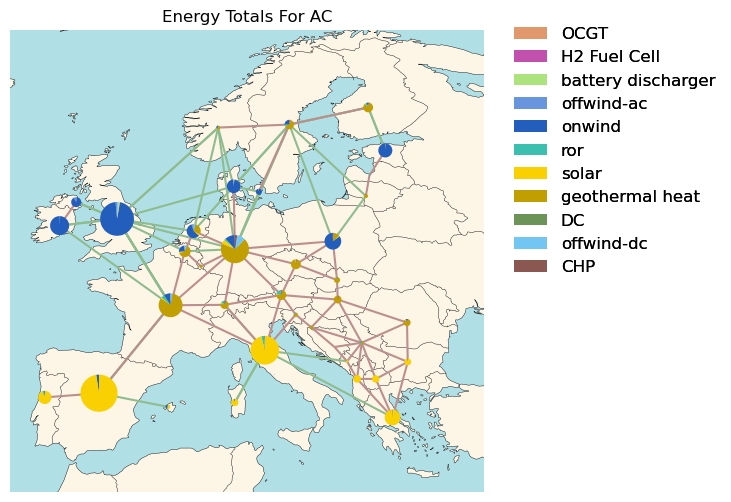

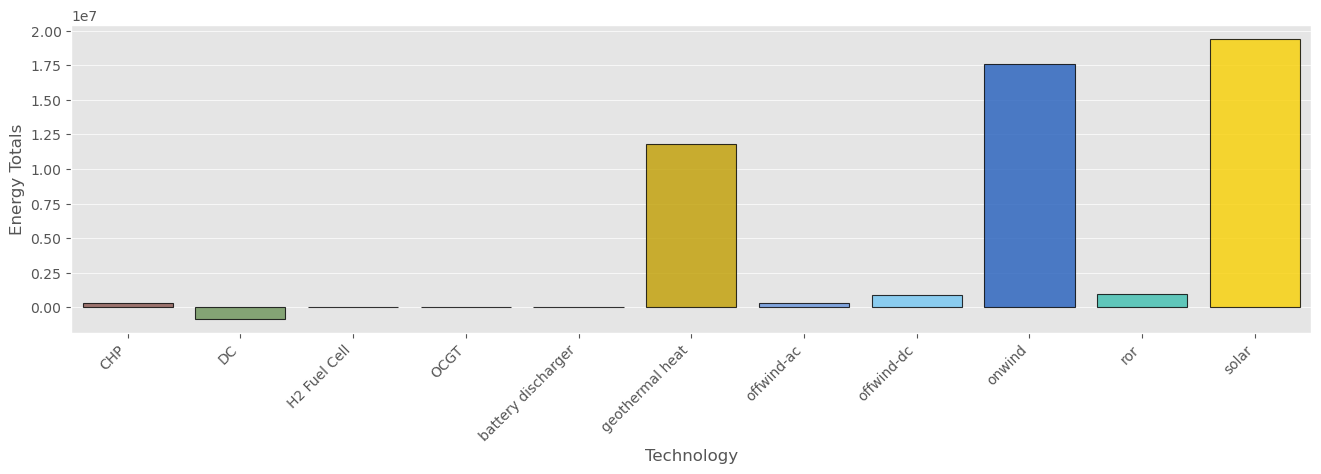

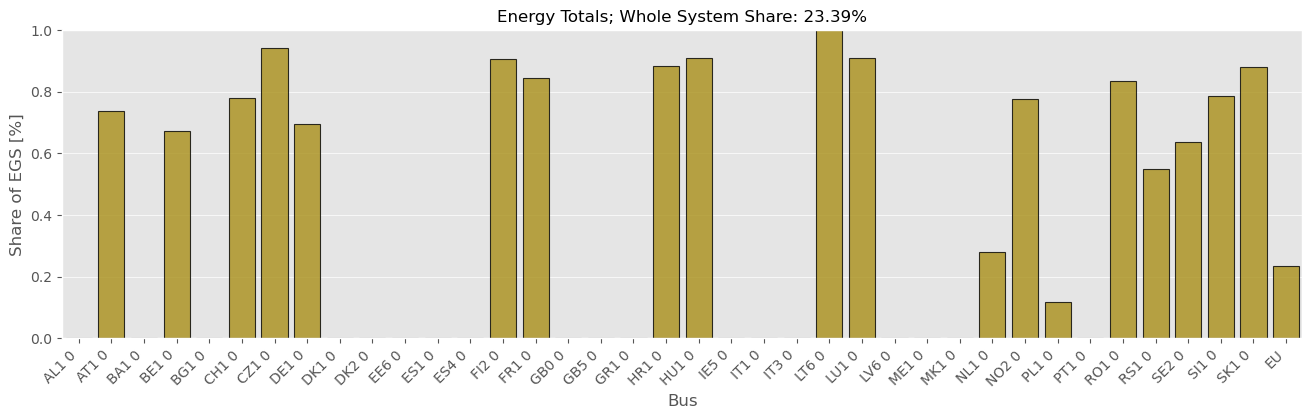

MultiIndex([('AL1 0',         'offwind-ac'),
            ('AL1 0',             'onwind'),
            ('AL1 0',                'ror'),
            ('AL1 0',              'solar'),
            ('AL1 0',       'H2 Fuel Cell'),
            ('AL1 0',               'OCGT'),
            ('AL1 0', 'battery discharger'),
            ('AL1 0',    'geothermal heat'),
            ('AL1 0',         'offwind-dc'),
            ('AL1 0',                 'DC'),
            ...
            ('SK1 0',             'onwind'),
            ('SK1 0',                'ror'),
            ('SK1 0',              'solar'),
            ('SK1 0',       'H2 Fuel Cell'),
            ('SK1 0',               'OCGT'),
            ('SK1 0', 'battery discharger'),
            ('SK1 0',    'geothermal heat'),
            ('SK1 0',         'offwind-dc'),
            ('SK1 0',                 'DC'),
            ('SK1 0',                'CHP')],
           names=[None, 'carrier'], length=407)


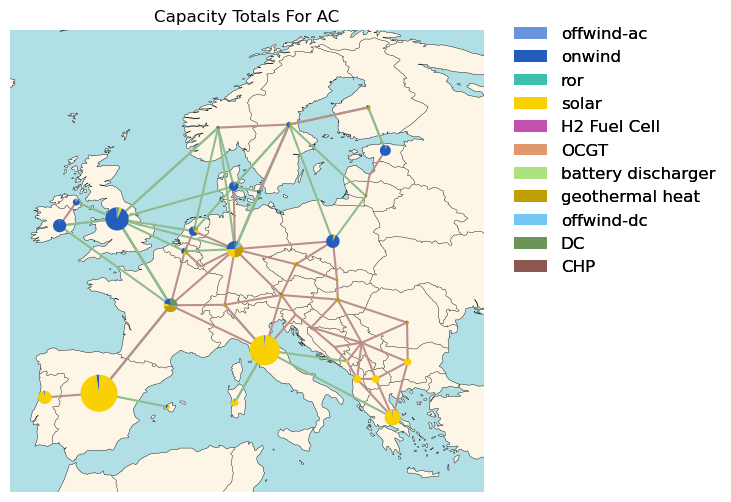

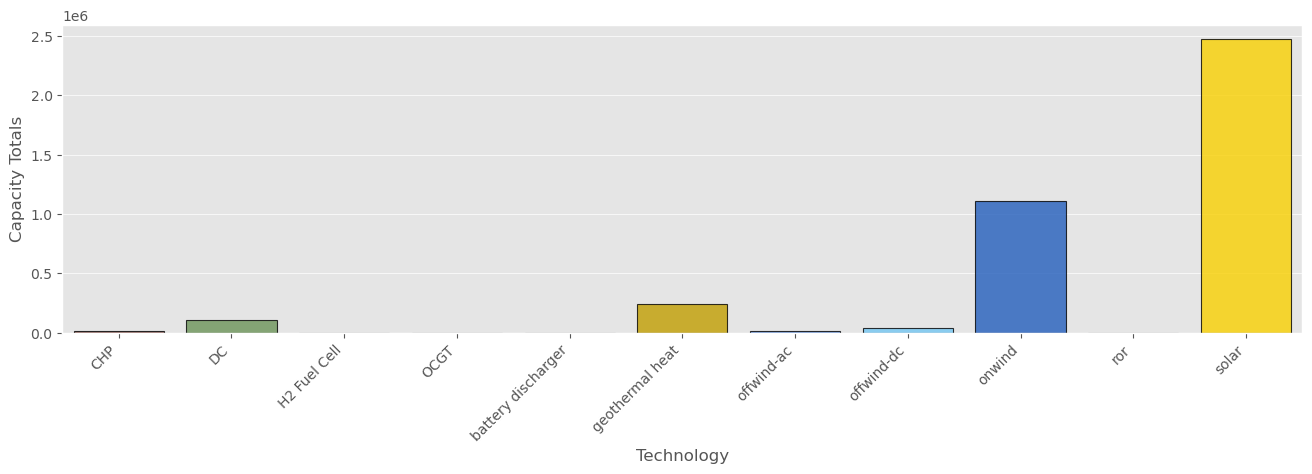

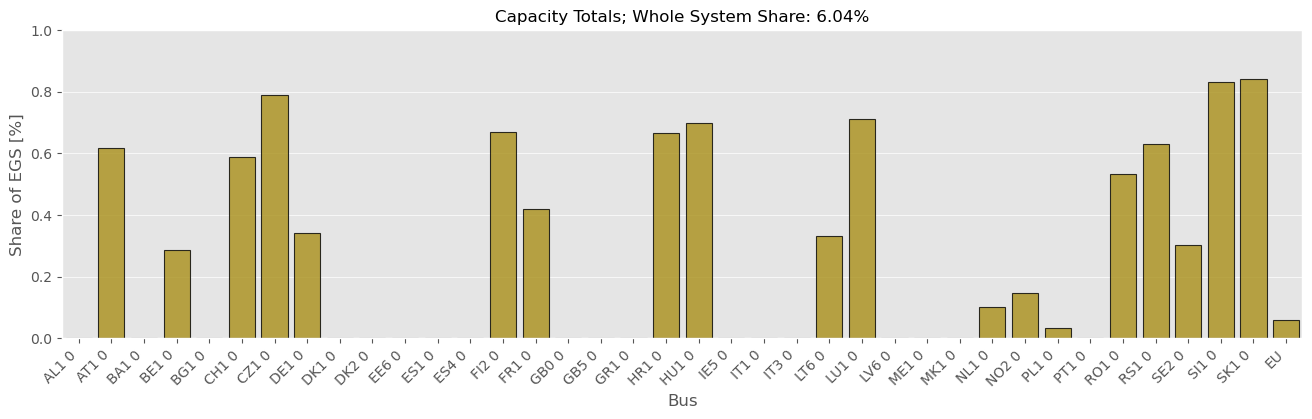

MultiIndex([('AL1 0',       'H2 Fuel Cell'),
            ('AL1 0',               'OCGT'),
            ('AL1 0', 'battery discharger'),
            ('AL1 0',         'offwind-ac'),
            ('AL1 0',             'onwind'),
            ('AL1 0',                'ror'),
            ('AL1 0',              'solar'),
            ('AL1 0',                'CHP'),
            ('AT1 0',       'H2 Fuel Cell'),
            ('AT1 0',               'OCGT'),
            ...
            ('SI1 0',              'solar'),
            ('SI1 0',                'CHP'),
            ('SK1 0',       'H2 Fuel Cell'),
            ('SK1 0',               'OCGT'),
            ('SK1 0', 'battery discharger'),
            ('SK1 0',    'geothermal heat'),
            ('SK1 0',             'onwind'),
            ('SK1 0',                'ror'),
            ('SK1 0',              'solar'),
            ('SK1 0',                'CHP')],
           names=['bus', 'carrier'], length=356)


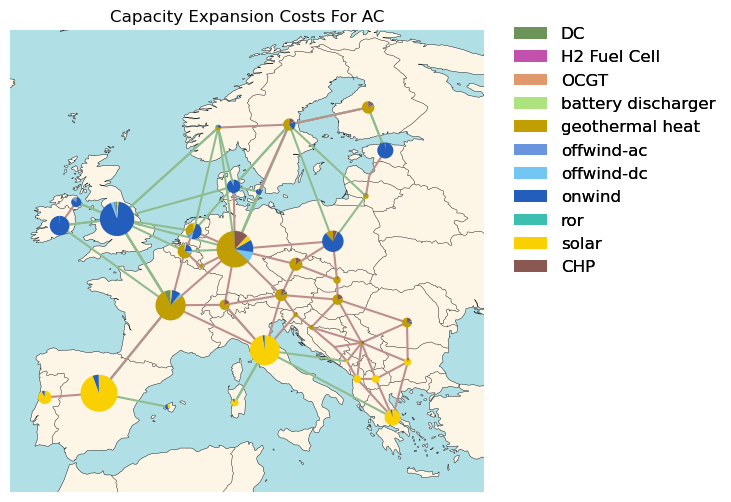

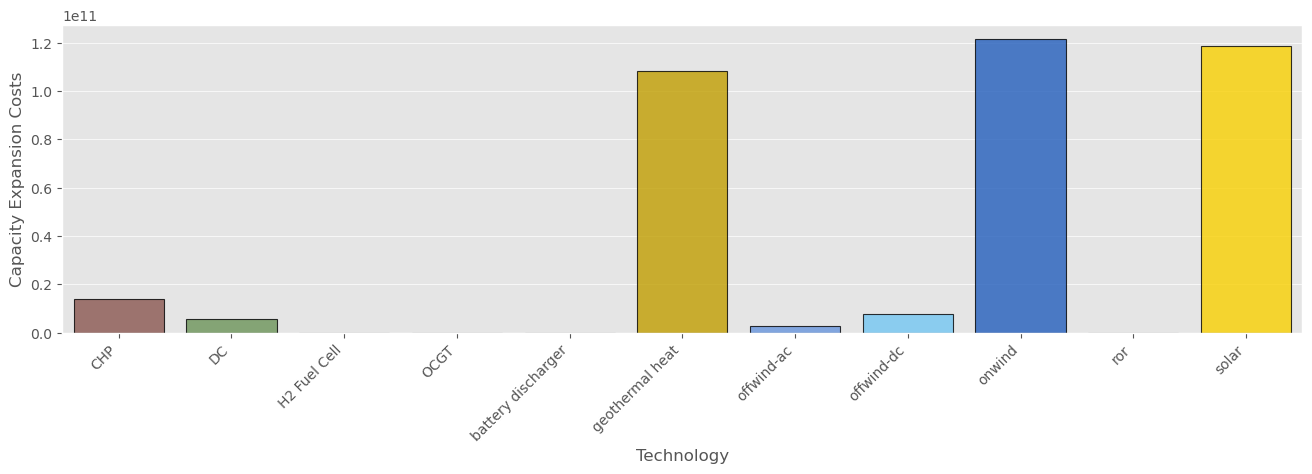

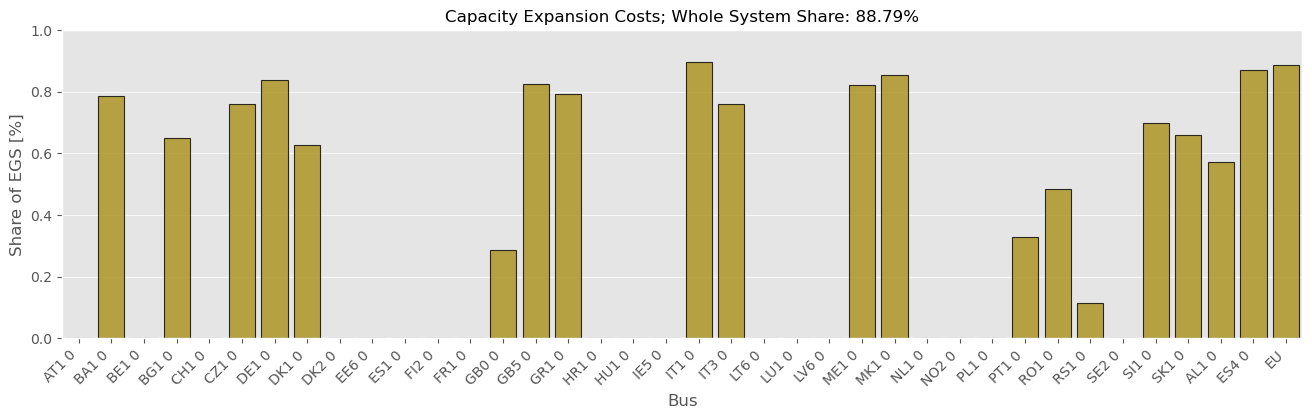

In [12]:
model_path = Path.cwd() / dir_template.format(450000) / "postnetworks" / model_name
n = pypsa.Network(model_path)

data = plot_geothermal_map(n, "AC", return_data=True, do_plot=True)

In [119]:
df = data.unstack()
chp_cols = [col for col in df.columns if "CHP" in col]

df["CHP"] = df[chp_cols].sum(axis=1)
df = df.drop(columns=chp_cols)
df.stack()


AL1 0  OCGT                       0.000015
       H2 Fuel Cell               0.000033
       battery discharger         0.000000
       offwind-ac                 0.000034
       onwind                     0.000029
                                 ...      
SK1 0  solar                   3544.184764
       geothermal heat       213952.175247
       DC                         0.000000
       offwind-dc                 0.000000
       CHP                     5052.233099
Length: 407, dtype: float64

In [200]:
pot_gdf.sort_values(by="CAPEX")

,p_nom_max,CAPEX,dh_share,geometry
200,0.000000,1250.489675,0.230114,"POLYGON ((10.00000 43.00000, 10.00000 44.00000..."
20,0.000000,1250.489675,0.230114,"POLYGON ((10.00000 43.00000, 10.00000 44.00000..."
591,0.000000,1250.489675,0.230114,"POLYGON ((10.00000 43.00000, 10.00000 44.00000..."
230,61.462237,1464.928382,0.000000,"POLYGON ((-21.00000 64.00000, -21.00000 65.000..."
636,61.462237,1464.928382,0.000000,"POLYGON ((-21.00000 64.00000, -21.00000 65.000..."
...,...,...,...,...
482,0.000000,11494.991867,0.350649,"POLYGON ((11.00000 49.00000, 11.00000 50.00000..."
350,9.635501,11511.760092,0.235060,"POLYGON ((17.00000 59.00000, 17.00000 60.00000..."
313,4.399796,11546.980984,0.000000,"POLYGON ((12.00000 79.00000, 12.00000 80.00000..."
348,8.331626,11647.250465,0.012821,"POLYGON ((16.00000 61.00000, 16.00000 62.00000..."


##### Geothermal Map

In [150]:
print(network_regions.head())


overlap_matrix = pd.DataFrame(index=network_regions.index, columns=egs_shapes.index)

for name, polygon in network_regions.geometry.items():
    overlap_matrix.loc[name] = egs_shapes.intersection(polygon).area / egs_shapes.area


    name                                           geometry
0  AL1 0  POLYGON ((20.32207 39.91318, 20.39703 39.81809...
1  AT1 0  POLYGON ((13.86068 46.51525, 13.67026 46.51871...
2  BA1 0  POLYGON ((17.82716 42.85312, 17.81176 42.90986...
3  BE1 0  POLYGON ((4.68192 50.08392, 4.67292 50.01638, ...
4  BG1 0  POLYGON ((23.94989 41.43758, 23.89480 41.46434...


NameError: name 'egs_shapes' is not defined

In [117]:
gpd.GeoSeries()
gpd.GeoSeries([pot_gdf.iloc[0].loc["geometry"].centroid]).set_crs(epsg=4326).estimate_utm_crs()

<Projected CRS: EPSG:32632>
Name: WGS 84 / UTM zone 32N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 6°E and 12°E, northern hemisphere between equator and 84°N, onshore and offshore. Algeria. Austria. Cameroon. Denmark. Equatorial Guinea. France. Gabon. Germany. Italy. Libya. Liechtenstein. Monaco. Netherlands. Niger. Nigeria. Norway. Sao Tome and Principe. Svalbard. Sweden. Switzerland. Tunisia. Vatican City State.
- bounds: (6.0, 0.0, 12.0, 84.0)
Coordinate Operation:
- name: UTM zone 32N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:


regions = gpd.read_file(Path.cwd() / ".." / ".." / "resource_backups" / "resources" / "egs_test" /
    "regions_onshore_elec_s_37.geojson")

regions.index = regions.name
regions = regions.drop(columns="name")
regions.head()

plot_geothermal_map(n, "AC")
plot_geothermal_map(n, "urban central heat")

In [ ]:
import seaborn as sns





get_geothermal_capacity_barchart(hold)

In [6]:
import yaml
from pathlib import Path

Path.cwd()
with open(Path.cwd() / ".." / "config.yaml") as f:
    cfg = yaml.safe_load(f)

cfg["run"]["name"] = "kannichdieconfigaendern"
cfg["sector"]["egs_fixed_capital_cost"] = 4.

with open(Path.cwd() / ".." / "kannichdieconfigaendern.yaml", "w") as f:
    yaml.dump(cfg, f)